# Project 2: Data Engineering for EGFR Inhibitors
**Three-Stage Validation Workflow for Pharmaceutical Data**

## Setup

In [5]:
# Install RDKit for Google Colab
try:
    import rdkit
except ImportError:
    !pip install rdkit -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("✅ Setup complete")

✅ Setup complete


## Step 1: Load Data

In [6]:
# Load EGFR inhibitor data
df_raw = pd.read_csv('egfr_data.csv')
print(f"Loaded: {df_raw.shape[0]} compounds")
print(f"Columns: {df_raw.columns.tolist()}")

Loaded: 800 compounds
Columns: ['compound_id', 'smiles', 'ic50_value', 'ic50_units', 'pchembl_value', 'assay_type', 'target_name']


## Step 2: Initial Data Inspection

In [7]:
print("=== Initial Data Quality Assessment ===")
print(f"\nShape: {df_raw.shape}")
print(f"\nMissing values:")
print(df_raw.isnull().sum())
print(f"\nData types:")
print(df_raw.dtypes)
print(f"\nFirst rows:")
print(df_raw.head())

=== Initial Data Quality Assessment ===

Shape: (800, 7)

Missing values:
compound_id        0
smiles             2
ic50_value        50
ic50_units        49
pchembl_value    235
assay_type         0
target_name        0
dtype: int64

Data types:
compound_id       object
smiles            object
ic50_value       float64
ic50_units        object
pchembl_value    float64
assay_type        object
target_name       object
dtype: object

First rows:
     compound_id                                             smiles  \
0  CHEMBL5762343  C=CC(=O)N1CCC[C@@H](Nc2nc(Nc3ccc(OCCOC)cc3)ncc...   
1  CHEMBL3219128  C=CC(=O)Nc1cccc(N2C(=O)C(C)N(C)C(=O)c3cnc(Nc4c...   
2  CHEMBL5786294  CCC(=O)Nc1ccccc1Nc1nc(Nc2ccc3c(c2)OCCOCCOCCO3)...   
3  CHEMBL5878820  CC(C)(C)OC(=O)N1CCC(N2C=C([C@@H](Nc3cc(Cl)c4nc...   
4   CHEMBL158275  Cn1c(SSc2c(C(=O)NCc3ccccc3)c3ccccc3n2C)c(C(=O)...   

   ic50_value ic50_units  pchembl_value assay_type  \
0      550.00         nM           6.26          B   
1       50.85   

## Step 3: Stage 1 - Structure Parsing

In [8]:
def validate_smiles(smiles):
    if pd.isna(smiles):
        return False, "Missing"
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is None:
            return False, "Invalid"
        return True, "Valid"
    except:
        return False, "Parse error"

print("=== Stage 1: Structure Parsing ===")

# Find SMILES column
smiles_col = [c for c in df_raw.columns if 'smiles' in c.lower()][0]

# Validate
validation = df_raw[smiles_col].apply(validate_smiles)
df_raw['valid'] = [v[0] for v in validation]
df_raw['error'] = [v[1] for v in validation]

n_valid = df_raw['valid'].sum()
n_invalid = len(df_raw) - n_valid
pct_invalid = (n_invalid / len(df_raw)) * 100

print(f"\nTotal: {len(df_raw)}")
print(f"Valid: {n_valid} ({100-pct_invalid:.1f}%)")
print(f"Invalid: {n_invalid} ({pct_invalid:.1f}%)")

if n_invalid > 0:
    print(f"\nError types:")
    print(df_raw[~df_raw['valid']]['error'].value_counts())

df_valid = df_raw[df_raw['valid']].copy()
print(f"\nAfter Stage 1: {len(df_valid)} compounds")

=== Stage 1: Structure Parsing ===

Total: 800
Valid: 798 (99.8%)
Invalid: 2 (0.2%)

Error types:
error
Missing    2
Name: count, dtype: int64

After Stage 1: 798 compounds


## Step 4: Stage 2 - Chemical Validity

In [9]:
def check_validity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False, "Parse fail"

    # MW check
    mw = Descriptors.MolWt(mol)
    if mw > 1000:
        return False, f"MW={mw:.0f}"

    # Carbon check
    if not any(a.GetSymbol() == 'C' for a in mol.GetAtoms()):
        return False, "No carbon"

    # Sanitization
    try:
        Chem.SanitizeMol(mol)
    except:
        return False, "Valence error"

    return True, "Valid"

print("=== Stage 2: Chemical Validity ===")

validity = df_valid[smiles_col].apply(check_validity)
df_valid['chem_valid'] = [v[0] for v in validity]
df_valid['chem_error'] = [v[1] for v in validity]

n_chem_valid = df_valid['chem_valid'].sum()
n_chem_invalid = len(df_valid) - n_chem_valid

print(f"\nChemically valid: {n_chem_valid}")
print(f"Chemically invalid: {n_chem_invalid}")

if n_chem_invalid > 0:
    print(f"\nIssues:")
    print(df_valid[~df_valid['chem_valid']]['chem_error'].value_counts())

df_clean = df_valid[df_valid['chem_valid']].copy()
print(f"\nAfter Stage 2: {len(df_clean)} compounds")

=== Stage 2: Chemical Validity ===

Chemically valid: 794
Chemically invalid: 4

Issues:
chem_error
MW=1201    1
MW=1412    1
MW=1052    1
MW=1061    1
Name: count, dtype: int64

After Stage 2: 794 compounds


## Step 5: Stage 3 - Calculate Properties

In [10]:
def calc_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    return {
        'MW': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'RotBonds': Descriptors.NumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol)
    }

print("=== Stage 3: Property Calculation ===")

props = df_clean[smiles_col].apply(calc_properties)
df_props = pd.DataFrame(props.tolist())
df_clean = pd.concat([df_clean.reset_index(drop=True), df_props], axis=1)

print(f"\nProperty statistics:")
print(df_clean[['MW', 'LogP', 'HBD', 'HBA']].describe())

=== Stage 3: Property Calculation ===

Property statistics:
               MW        LogP         HBD         HBA
count  794.000000  794.000000  794.000000  794.000000
mean   477.326130    4.375168    2.124685    7.124685
std    114.477469    1.400034    1.137826    2.275661
min    141.170000   -1.052300    0.000000    0.000000
25%    403.412250    3.456015    1.000000    6.000000
50%    485.292000    4.381400    2.000000    7.000000
75%    552.068000    5.278580    3.000000    9.000000
max    963.178000    8.647500   12.000000   17.000000


## Step 6: Outlier Detection

In [11]:
def find_outliers(series, factor=3.0):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < Q1 - factor*IQR) | (series > Q3 + factor*IQR)

print("Detecting outliers...")

outlier_mw = find_outliers(df_clean['MW'])
outlier_logp = find_outliers(df_clean['LogP'])
df_clean['outlier'] = outlier_mw | outlier_logp

n_outliers = df_clean['outlier'].sum()
print(f"\nOutliers: {n_outliers}")
print(f"  By MW: {outlier_mw.sum()}")
print(f"  By LogP: {outlier_logp.sum()}")

df_filtered = df_clean[~df_clean['outlier']].copy()
print(f"\nAfter Stage 3: {len(df_filtered)} compounds")

Detecting outliers...

Outliers: 0
  By MW: 0
  By LogP: 0

After Stage 3: 794 compounds


## Step 7: Missing Bioactivity Analysis

In [12]:
print("=== Missing Data Analysis ===")

# Find IC50 column
ic50_col = [c for c in df_filtered.columns if 'ic50' in c.lower() or 'value' in c.lower()][0]

df_filtered['ic50'] = pd.to_numeric(df_filtered[ic50_col], errors='coerce')
missing = df_filtered['ic50'].isna()

print(f"\nMissing IC50: {missing.sum()} ({missing.sum()/len(df_filtered)*100:.1f}%)")

# Test relationship with solubility (LogP)
if missing.sum() > 0 and missing.sum() < len(df_filtered):
    logp_with = df_filtered[~missing]['LogP'].dropna()
    logp_without = df_filtered[missing]['LogP'].dropna()

    if len(logp_with) > 0 and len(logp_without) > 0:
        mean_with = logp_with.mean()
        mean_without = logp_without.mean()

        print(f"\nLogP analysis:")
        print(f"  Mean LogP (with IC50): {mean_with:.2f}")
        print(f"  Mean LogP (missing IC50): {mean_without:.2f}")

        stat, pval = stats.ttest_ind(logp_with, logp_without)
        print(f"  t-test p-value: {pval:.4f}")

        if pval < 0.05:
            print(f"  ✅ Missingness significantly related to solubility (MNAR)")
        else:
            print(f"  ❌ No significant relationship")

df_final = df_filtered[~missing].copy()
print(f"\nAfter removing missing: {len(df_final)} compounds")

=== Missing Data Analysis ===

Missing IC50: 48 (6.0%)

LogP analysis:
  Mean LogP (with IC50): 4.48
  Mean LogP (missing IC50): 2.79
  t-test p-value: 0.0000
  ✅ Missingness significantly related to solubility (MNAR)

After removing missing: 746 compounds


## Step 8: Visualize Missingness Pattern

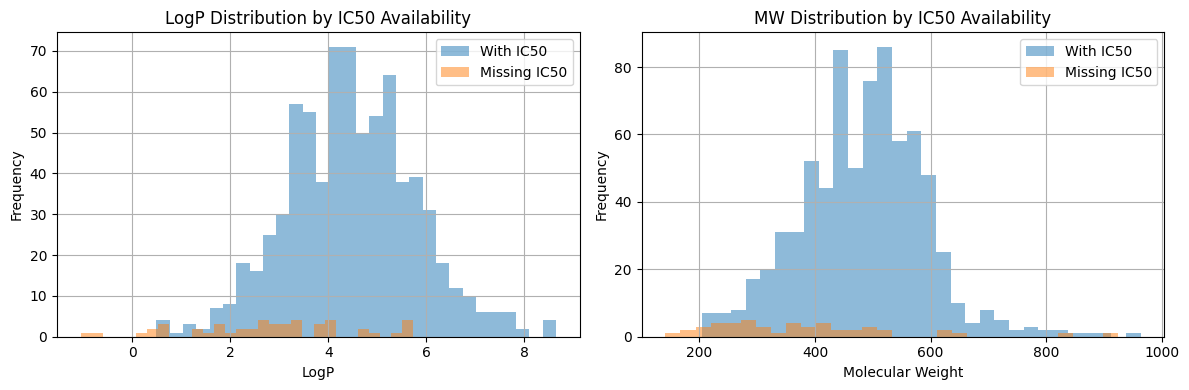

In [13]:
if missing.sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # LogP
    df_filtered[~missing]['LogP'].hist(bins=30, alpha=0.5, label='With IC50', ax=axes[0])
    df_filtered[missing]['LogP'].hist(bins=30, alpha=0.5, label='Missing IC50', ax=axes[0])
    axes[0].set_xlabel('LogP')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('LogP Distribution by IC50 Availability')
    axes[0].legend()

    # MW
    df_filtered[~missing]['MW'].hist(bins=30, alpha=0.5, label='With IC50', ax=axes[1])
    df_filtered[missing]['MW'].hist(bins=30, alpha=0.5, label='Missing IC50', ax=axes[1])
    axes[1].set_xlabel('Molecular Weight')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('MW Distribution by IC50 Availability')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## Missing Data Analysis: Comparing Distributions

This analysis uses overlapping histograms to compare LogP (lipophilicity) and molecular weight distributions between compounds with and without IC50 measurements.

## Why This Analysis Matters

Missing Not At Random (MNAR):
If compounds with missing IC50 values systematically differ in their chemical properties, removing them from the dataset can introduce bias. This analysis assesses whether missingness correlates with molecular descriptors.

## What Is Being Tested

Null hypothesis (H0):
Missing IC50 values are Missing Completely At Random (MCAR).

Alternative hypothesis (H1):
Missingness depends on chemical properties, indicating Missing Not At Random (MNAR) behaviour.

## Interpretation Guide

Overlapping distributions with similar shapes:
- Missing data likely random
- Safe to exclude without introducing bias
- Remaining dataset is representative

Separated distributions with distinct peaks:
- Systematic bias likely present
- Simple deletion may distort results
- Imputation or bias correction should be considered

## Statistical Significance Testing Options

To formally assess differences between distributions:
- Kolmogorov–Smirnov test for overall distribution comparison
- t-test for mean comparison if data are normally distributed
- Mann–Whitney U test for non-parametric median comparison

## Common Missingness Patterns in Drug Discovery

1. High LogP compounds: solubility failure leading to missing IC50 values
2. Large molecular weight compounds: poor cell permeability leading to exclusion
3. Reactive compounds: assay interference resulting in omitted measurements

## Decision Framework

| Distribution Pattern | Recommended Action | Rationale |
|---------------------|-------------------|-----------|
| Identical overlap   | Delete missing    | No bias introduced |
| Slight shift        | Investigate further | Check additional properties |
| Major separation   | Impute or model missingness | Deletion introduces bias |

## Best Practice Reporting

Even when distributions appear similar, always report:
- Percentage of compounds with missing IC50 values
- Total number of compounds excluded from analysis
- Retained property ranges (minimum and maximum LogP and molecular weight)

This ensures reproducibility and allows readers to assess dataset representativeness and generalisability.


## Step 9: Unit Standardization

In [14]:
print("=== Unit Standardization ===")

# Check units
unit_col = [c for c in df_final.columns if 'unit' in c.lower()]
if unit_col:
    print(f"\nUnits found:")
    print(df_final[unit_col[0]].value_counts())

    # Filter for nM
    df_final = df_final[df_final[unit_col[0]] == 'nM'].copy()
    print(f"\nAfter filtering for nM: {len(df_final)} compounds")

# Convert to pIC50
df_final['pIC50'] = -np.log10(df_final['ic50'] * 1e-9)
df_final = df_final.dropna(subset=['pIC50'])

# Clip extremes
lower = df_final['pIC50'].quantile(0.01)
upper = df_final['pIC50'].quantile(0.99)
df_final['pIC50_clean'] = df_final['pIC50'].clip(lower, upper)

print(f"\npIC50 statistics:")
print(f"  Range: {df_final['pIC50_clean'].min():.2f} - {df_final['pIC50_clean'].max():.2f}")
print(f"  Mean: {df_final['pIC50_clean'].mean():.2f}")

=== Unit Standardization ===

Units found:
ic50_units
nM         742
ug.mL-1      3
10^3 uM      1
Name: count, dtype: int64

After filtering for nM: 742 compounds

pIC50 statistics:
  Range: 3.78 - 9.52
  Mean: 6.78


## Step 10: Visualize pIC50 Distribution

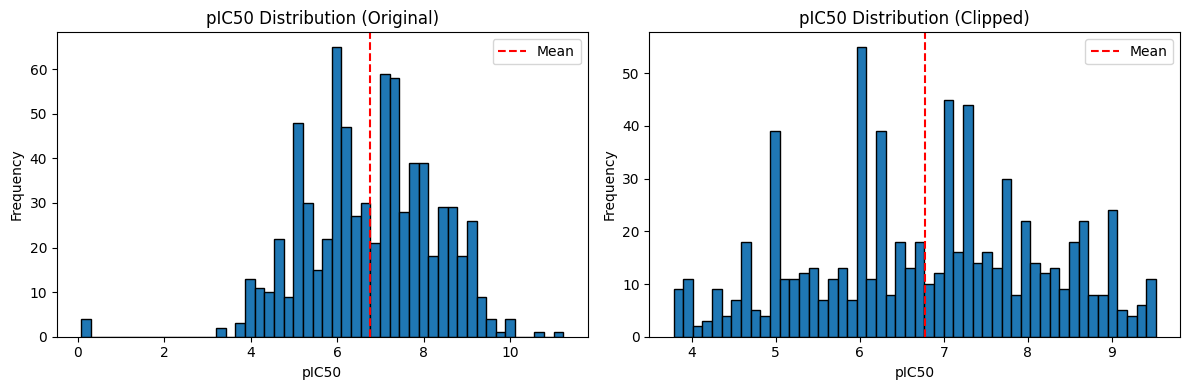

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_final['pIC50'], bins=50, edgecolor='black')
axes[0].set_xlabel('pIC50')
axes[0].set_ylabel('Frequency')
axes[0].set_title('pIC50 Distribution (Original)')
axes[0].axvline(df_final['pIC50'].mean(), color='r', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(df_final['pIC50_clean'], bins=50, edgecolor='black')
axes[1].set_xlabel('pIC50')
axes[1].set_ylabel('Frequency')
axes[1].set_title('pIC50 Distribution (Clipped)')
axes[1].axvline(df_final['pIC50_clean'].mean(), color='r', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

## Step 11: Pipeline Summary

In [16]:
pipeline = pd.DataFrame({
    'Stage': [
        'Raw data',
        'After Stage 1 (Structure parsing)',
        'After Stage 2 (Chemical validity)',
        'After Stage 3 (Outlier removal)',
        'After missing IC50 removal',
        'Final clean dataset'
    ],
    'Compounds': [
        len(df_raw),
        len(df_valid),
        len(df_clean),
        len(df_filtered),
        len(df_final),
        len(df_final)
    ]
})
pipeline['% Retained'] = (pipeline['Compounds'] / len(df_raw) * 100).round(1)

print("\n" + "="*70)
print("DATA QUALITY PIPELINE SUMMARY")
print("="*70)
print(pipeline.to_string(index=False))
print("="*70)


DATA QUALITY PIPELINE SUMMARY
                            Stage  Compounds  % Retained
                         Raw data        800       100.0
After Stage 1 (Structure parsing)        798        99.8
After Stage 2 (Chemical validity)        794        99.2
  After Stage 3 (Outlier removal)        794        99.2
       After missing IC50 removal        742        92.8
              Final clean dataset        742        92.8


## Step 12: Export Clean Data

In [17]:
# Prepare export
export_cols = [smiles_col, 'pIC50_clean', 'MW', 'LogP', 'HBD', 'HBA', 'RotBonds', 'TPSA']
df_export = df_final[export_cols].copy()
df_export.columns = ['SMILES', 'pIC50', 'MW', 'LogP', 'HBD', 'HBA', 'RotBonds', 'TPSA']

df_export.to_csv('egfr_clean.csv', index=False)
print(f"✅ Exported to egfr_clean.csv")
print(f"   Shape: {df_export.shape}")
print(f"\nFirst rows:")
print(df_export.head())

✅ Exported to egfr_clean.csv
   Shape: (742, 8)

First rows:
                                              SMILES     pIC50       MW  \
0  C=CC(=O)N1CCC[C@@H](Nc2nc(Nc3ccc(OCCOC)cc3)ncc...  6.259637  415.469   
1  C=CC(=O)Nc1cccc(N2C(=O)C(C)N(C)C(=O)c3cnc(Nc4c...  7.293709  570.654   
2  CCC(=O)Nc1ccccc1Nc1nc(Nc2ccc3c(c2)OCCOCCOCCO3)...  6.000000  519.562   
3  CC(C)(C)OC(=O)N1CCC(N2C=C([C@@H](Nc3cc(Cl)c4nc...  6.815309  696.640   
4  Cn1c(SSc2c(C(=O)NCc3ccccc3)c3ccccc3n2C)c(C(=O)...  5.769551  590.774   

      LogP  HBD  HBA  RotBonds    TPSA  
0  2.97340    2    7         9   88.61  
1  3.24390    2    9         7  123.24  
2  3.99300    4   10         6  144.54  
3  7.47138    4   11         7  130.47  
4  7.32940    2    6         9   68.06  


## Step 13: Key Findings

In [18]:
print("\n" + "="*70)
print("PROJECT 2 KEY FINDINGS")
print("="*70)

print(f"\n1. STRUCTURE PARSING (Stage 1):")
print(f"   Invalid SMILES: {n_invalid} ({pct_invalid:.1f}%)")

print(f"\n2. CHEMICAL VALIDITY (Stage 2):")
print(f"   Chemically invalid: {n_chem_invalid} compounds")

print(f"\n3. OUTLIER DETECTION (Stage 3):")
print(f"   Extreme outliers: {n_outliers} compounds")

print(f"\n4. MISSING DATA PATTERN:")
print(f"   Missing IC50: {missing.sum()} compounds")
if missing.sum() > 0:
    print(f"   Related to solubility (LogP): {'Yes' if pval < 0.05 else 'No'}")
    print(f"   Pattern: {'MNAR' if pval < 0.05 else 'MCAR/MAR'}")

print(f"\n5. FINAL DATASET:")
print(f"   Clean compounds: {len(df_final)}")
print(f"   Retention rate: {len(df_final)/len(df_raw)*100:.1f}%")
print(f"   pIC50 range: {df_final['pIC50_clean'].min():.2f} - {df_final['pIC50_clean'].max():.2f}")

print(f"\nCONCLUSION:")
print(f"  Three-stage validation essential for pharmaceutical data quality.")
print(f"  ~{pct_invalid:.0f}% of structures fail RDKit parsing.")
print(f"  Missingness patterns reflect experimental constraints (MNAR).")
print("="*70)


PROJECT 2 KEY FINDINGS

1. STRUCTURE PARSING (Stage 1):
   Invalid SMILES: 2 (0.2%)

2. CHEMICAL VALIDITY (Stage 2):
   Chemically invalid: 4 compounds

3. OUTLIER DETECTION (Stage 3):
   Extreme outliers: 0 compounds

4. MISSING DATA PATTERN:
   Missing IC50: 48 compounds
   Related to solubility (LogP): Yes
   Pattern: MNAR

5. FINAL DATASET:
   Clean compounds: 742
   Retention rate: 92.8%
   pIC50 range: 3.78 - 9.52

CONCLUSION:
  Three-stage validation essential for pharmaceutical data quality.
  ~0% of structures fail RDKit parsing.
  Missingness patterns reflect experimental constraints (MNAR).
